Vamos a crear un modelo con ngram de contexto que sea capaz de escribir una canción infantil, basándonos en canciones infantiles.

# IMPORTS

In [1]:
!pip uninstall -y torch
!pip install torch==2.0.1 torchtext==0.15.2

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.5 MB/s eta 0:00:00


In [2]:
%%capture

!mamba install -y nltk
!pip install torchtext -qqq

In [3]:
%%capture
import warnings
from tqdm import tqdm

warnings.simplefilter('ignore')
import time
from collections import OrderedDict

import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import nltk
nltk.download('punkt')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string
import time

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
%capture

In [4]:
# primero cogemos la función que limpia el texto
def preprocess_string(s):
    # eliminamos todo lo que no sea una letra número espacio o guión bajo y lo elimina
    s = re.sub(r"[^\w\s]", '', s)
    # busca espacios en blanco de más de un espacio o saltos de línea y los elimina
    s = re.sub(r"\s+", '', s)
    # elimina los dígitos de la cadena
    s = re.sub(r"\d", '', s)

    return s

# DATA

In [5]:
nursery_rhymes = """
Little Miss Muffet
Sat on a tuffet,
Eating her curds and whey;
Along came a spider
Who sat down beside her
And frightened Miss Muffet away.

Twinkle, twinkle, little star,
How I wonder what you are!
Up above the world so high,
Like a diamond in the sky.

Baa, baa, black sheep,
Have you any wool?
Yes sir, yes sir,
Three bags full.

Jack and Jill went up the hill
To fetch a pail of water.
Jack fell down and broke his crown,
And Jill came tumbling after.

Hickory dickory dock,
The mouse ran up the clock.
The clock struck one,
The mouse ran down,
Hickory dickory dock.

Humpty Dumpty sat on a wall,
Humpty Dumpty had a great fall.
All the king's horses and all the king's men
Couldn't put Humpty together again.

Mary had a little lamb,
Its fleece was white as snow;
And everywhere that Mary went,
The lamb was sure to go.

Old MacDonald had a farm,
E-I-E-I-O,
And on his farm he had a cow,
E-I-E-I-O.

Itsy Bitsy Spider climbed up the waterspout.
Down came the rain and washed the spider out.
Out came the sun and dried up all the rain,
And the Itsy Bitsy Spider climbed up the spout again.

The wheels on the bus go round and round,
Round and round,
Round and round.
The wheels on the bus go round and round,
All through the town.

Hey diddle diddle,
The cat and the fiddle,
The cow jumped over the moon.
The little dog laughed to see such fun,
And the dish ran away with the spoon.

London Bridge is falling down,
Falling down, falling down,
London Bridge is falling down,
My fair lady.

Row, row, row your boat,
Gently down the stream.
Merrily, merrily, merrily, merrily,
Life is but a dream.

Pat-a-cake, pat-a-cake, baker's man,
Bake me a cake as fast as you can;
Pat it and prick it and mark it with B,
And put it in the oven for baby and me.

Rain, rain, go away,
Come again another day.
Little Johnny wants to play,
Rain, rain, go away.

This old man, he played one,
He played knick-knack on my thumb;
With a knick-knack paddywhack, give a dog a bone,
This old man came rolling home.

Rock-a-bye baby, on the treetop,
When the wind blows, the cradle will rock.
When the bough breaks, the cradle will fall,
And down will come baby, cradle and all.

Three blind mice, three blind mice,
See how they run, see how they run!
They all ran after the farmer's wife,
Who cut off their tails with a carving knife.
Did you ever see such a sight in your life,
As three blind mice?

Yankee Doodle went to town,
Riding on a pony;
He stuck a feather in his hat,
And called it macaroni.

There was an old woman who lived in a shoe,
She had so many children, she didn’t know what to do.
She gave them some broth without any bread,
Then whipped them all soundly and put them to bed.

Star light, star bright,
First star I see tonight,
I wish I may, I wish I might,
Have the wish I wish tonight.

Hot cross buns! Hot cross buns!
One a penny, two a penny,
Hot cross buns!
If you have no daughters, give them to your sons.

Sing a song of sixpence,
A pocket full of rye.
Four and twenty blackbirds,
Baked in a pie.
When the pie was opened,
The birds began to sing;
Wasn’t that a dainty dish,
To set before the king?

The grand old Duke of York,
He had ten thousand men.
He marched them up to the top of the hill,
And he marched them down again.

If you’re happy and you know it, clap your hands.
If you’re happy and you know it, clap your hands.
If you’re happy and you know it,
And you really want to show it,
If you’re happy and you know it, clap your hands.

Five little ducks went swimming one day,
Over the hills and far away.
Mother duck said, "Quack, quack, quack, quack,"
But only four little ducks came back.

I’m a little teapot,
Short and stout,
Here is my handle,
Here is my spout.
When I get all steamed up,
Hear me shout,
"Tip me over and pour me out!"

She’ll be coming ‘round the mountain when she comes,
She’ll be coming ‘round the mountain when she comes.
She’ll be coming ‘round the mountain,
She’ll be coming ‘round the mountain,
She’ll be coming ‘round the mountain when she comes.

Pop! Goes the weasel.
Half a pound of tuppenny rice,
Half a pound of treacle.
Mix it up and make it nice,
Pop! Goes the weasel.

Do you know the Muffin Man,
The Muffin Man, the Muffin Man?
Do you know the Muffin Man,
Who lives on Drury Lane?
"""


# TOKENIZER-vocab-indexer



In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [7]:
# tokenizer
tokenizer = get_tokenizer("basic_english")
tokens=tokenizer(nursery_rhymes)

In [8]:
# Create a vocabulary

tokenized_song = map(tokenizer, nursery_rhymes.split())

# Step 2: Vocabulary Building

vocab = build_vocab_from_iterator(tokenized_song, specials=["<unk>"])

# Step 3: Set Default Index

vocab.set_default_index(vocab["<unk>"])

In [9]:
index_to_token = vocab.get_itos()
index_to_token[0]

'<unk>'

In [10]:
def text_pipeline(x):
    return vocab(tokenizer(x))

text_pipeline("Little Miss Muffet guadalajara")

[15, 127, 129, 0]

# COLLATE , BATCH FUNCTION AND DATA LOADER

In [11]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #usamos gpu

In [12]:
CONTEXT_SIZE=32
BATCH_SIZE=100
EMBEDDING_DIM = 40

# definimos la función de collate
def collate_batch(batch):
    batch_size=len(batch)
    context, target=[],[]  # hacemos el X, Y, siendo contexto X y el target Y
    for i in range(CONTEXT_SIZE,batch_size):
        # lo transforma a  índices de vocabulario
        target.append(vocab([batch[i]]))
        context.append(vocab([batch[i-j-1] for j in range(CONTEXT_SIZE)]))

    # SACAMOS LOS TENSORES NECESARIOS METIENDOLOS EN LA GPU PARA QUE NO HAYA PROBLEMAS
    return   torch.tensor(context).to(device),  torch.tensor(target).to(device).reshape(-1)

In [13]:
# añadimos padding, hacemos que pasen al final las primeras palabras para que sea
# múltiplo de batch los tokens.
Padding=BATCH_SIZE-len(tokens)%BATCH_SIZE
tokens_pad=tokens+tokens[0:Padding]

## DATA LOADER

In [14]:
dataloader = DataLoader(
     tokens_pad, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)

# MULTICLASS NEURAL NETWORK

In [15]:
# CREAMOS LA CLASE DEL MODELO
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size): #n_vocab, n_emb, n_context

        super(NGramLanguageModeler, self).__init__()
        self.context_size=context_size
        self.embedding_dim=embedding_dim
        # PRIMERA CAPA DE EMBEDDING
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        # CREAMOS LA PRIMERA CAPA LINEAR CON ENTRADA CONTEXT* EMBEDDING
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        # SEGUNDA CAPA QUE LA SALIDA ES LA DIMENSIÓN DEL VOCABULARIO
        self.linear2 = nn.Linear(128, vocab_size)

    #RECORRIDO DE LOS DATOS POR LA RED O MODELO
    def forward(self, inputs):
        # creamos los embeddings de la entrada
        embeds = self.embeddings(inputs)
        # los aplanamos
        embeds=torch.reshape( embeds, (-1,self.context_size * self.embedding_dim))

        # primera capa linear que le metemos activación Relu
        # e introducimos de esta forma no linealidad, salida sera de 128
        out = F.relu(self.linear1(embeds))

        # Generamos las puntuaciones de cada palabra
        out = self.linear2(out)

        return out

# TRAIN

In [16]:
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

In [17]:
# DEFINIMOS LA FUNCIÓN DE PÉRDIDA
criterion = torch.nn.CrossEntropyLoss()

In [22]:
def write_song(model,number_of_words=100):
    my_song=""
    for i in range(number_of_words):
        with torch.no_grad():
            context=torch.tensor(vocab([tokens[i-j-1] for j in range(CONTEXT_SIZE)])).to(device)
            word_inx=torch.argmax(model(context))
            my_song+=" "+index_to_token[word_inx.detach().item()]

    return my_song

In [18]:
def train(dataloader, model, number_of_epochs=1000, show=10):

    MY_LOSS = []  # List to store loss values for each epoch

    # Iterate over the specified number of epochs
    for epoch in tqdm(range(number_of_epochs)):
        total_loss = 0  # Initialize total loss for the current epoch
        my_song = ""    # Initialize a string to store the generated song

        # Iterate over batches in the dataloader
        for context, target in dataloader:
            model.zero_grad()          # Zero the gradients to avoid accumulation
            predicted = model(context)  # Forward pass through the model to get predictions
            loss = criterion(predicted, target.reshape(-1))  # Calculate the loss
            total_loss += loss.item()   # Accumulate the loss

            loss.backward()    # Backpropagation to compute gradients
            optimizer.step()   # Update model parameters using the optimizer

        # Display progress and generate song at specified intervals
        if epoch % show == 0:
            my_song += write_song(model)  # Generate song using the model

            print("Generated Song:")
            print("\n")
            print(my_song)

        MY_LOSS.append(total_loss/len(dataloader))  # Append the total loss for the epoch to MY_LOSS list

    return MY_LOSS  # Return the list of  mean loss values for each epoch

In [19]:
my_loss_list=[]

In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.1)

In [23]:
my_loss=train(dataloader,model )

save_path = '/content/drive/Othercomputers/Mi portátil/apuntes/modulo3/practice/write_song_infantil.pth'
torch.save(model.state_dict(), save_path)

my_loss_list.append(my_loss)

  1%|          | 8/1000 [00:00<00:26, 37.44it/s]

Generated Song:


 jack sky played pound goes bus did but life london did did goes world how b bridge but black handle ! baker above bread b black did goes fun along along did goes four tonight round jumped in b life fun how tonight round can so did birds b humpty pound come come . riding in but life white as did sat london hear couldn mice water ducks in come london began . london did bus water round round london mouse knife did dog goes my london tonight black bus , one pound how riding another called birds like bridge


  2%|▏         | 16/1000 [00:00<00:26, 36.65it/s]

Generated Song:


 the , , , , , , , , , , , , , , , , , , , , , , , . , , , , , the , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , a , , the , , , , , , , , , , , , , , , ,


  3%|▎         | 26/1000 [00:00<00:25, 37.76it/s]

Generated Song:


 , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,


  4%|▎         | 36/1000 [00:00<00:25, 37.97it/s]

Generated Song:


 the the the , , , , , , , , , , and , the , , , , , the , , . , , , , , the , , , , , , , , , , the , , the , , , , and , , , the , . , , , , and , , , , , the the , , , , , , , , , . , and a , , the , , , , , , , , , , , , , . , ,


  5%|▍         | 49/1000 [00:01<00:24, 38.24it/s]

Generated Song:


 the and and , , a , , , , , , , and , a , , , and , the , , . , , , , a the , , , , , and , , you , the , , the , , , , and a , a the and . , , and , and , , , a a the the , . , , . , , , , . , and a and and the , , , a , , , . , and the and . . and ,


  6%|▌         | 58/1000 [00:01<00:25, 37.23it/s]

Generated Song:


 the and and , , a a , , , , , , and , a a , , and , a , and . , , , , a the , little , , , i a , you , the up , the , , a , and a , a the and . , , and , and , , , a a the the . . , , . , , the , . . and a and up the , , , a , , , . , and the and . . and ,


  7%|▋         | 67/1000 [00:01<00:24, 38.06it/s]

Generated Song:


 the and and , on a a , , a and , , and it a a , , and , a , and . , , , , a the , little , , , i a , you , ! up , the , . a , and a , a the and . , , and , and , , , you a the the yes . , , . , , the , . jack and a and up the , , , a , of , . jack and the and . . and ,


  8%|▊         | 76/1000 [00:02<00:24, 37.93it/s]

Generated Song:


 little and and , on a a , , a and , . and it a a , , on , a , and . , , , , a the the little , , , i a what you , ! up above the , so a , and a , in the and . , , and , and , , have you a the ? yes . , , . , . the full . jack and a went up the , , , a , of , . jack fell the and . . and ,


  9%|▉         | 89/1000 [00:02<00:23, 39.14it/s]

Generated Song:


 little and and sat on a a , , a and , . and it a you , , on , a , and . , , , , a the the little , , , i wonder what you are ! up above the , so a , and a diamond in the sky . baa , baa , black he , have you a the ? yes . , , sir , three the full . jack and a went up the hill to fetch a , of , . jack fell down and . his it ,


 10%|▉         | 98/1000 [00:02<00:23, 38.59it/s]

Generated Song:


 little and and sat on a a , eating a and , . and it a you , , on , a , merrily . , , , a a the the little , , , i wonder what you are ! up above the , so a , and a diamond in the sky . baa , baa , black sheep , have you a the ? yes . , yes sir , three the full . jack and a went up the hill to fetch a pail of , . jack fell down and broke his it ,


 11%|█         | 107/1000 [00:02<00:23, 38.20it/s]

Generated Song:


 little and and sat on a tuffet , eating a and , . it it a you , , on , a , merrily a , , , a a the the little star , , i wonder what you are ! up above the , so high , a a diamond in the sky . baa , baa , black sheep , have you a wool ? yes sir , yes sir , three the full . jack and a went up the hill to fetch a pail of water . jack fell down and broke his it ,


 12%|█▏        | 115/1000 [00:03<00:23, 36.99it/s]

Generated Song:


 little and muffet sat on a tuffet , eating a curds , . it it a know , to on , a , merrily a , , , a a the the little star , how i wonder what you are ! up above the , so high , a a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 13%|█▎        | 128/1000 [00:03<00:23, 37.47it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , . my it a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 14%|█▎        | 137/1000 [00:03<00:23, 37.14it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , . my it a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 15%|█▍        | 146/1000 [00:03<00:22, 37.24it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , . my it a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 16%|█▌        | 159/1000 [00:04<00:23, 36.07it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , . my it a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 17%|█▋        | 167/1000 [00:04<00:23, 35.84it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my it a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 18%|█▊        | 176/1000 [00:04<00:22, 37.21it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my it a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 19%|█▊        | 186/1000 [00:05<00:21, 37.87it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my it a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 20%|█▉        | 199/1000 [00:05<00:20, 38.25it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my it a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 21%|██        | 207/1000 [00:05<00:21, 36.74it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my it a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 22%|██▏       | 216/1000 [00:05<00:20, 37.73it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my it a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 22%|██▎       | 225/1000 [00:06<00:21, 36.88it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my it a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 24%|██▍       | 239/1000 [00:06<00:19, 38.55it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my it a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 25%|██▍       | 248/1000 [00:06<00:20, 37.55it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my it a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 26%|██▌       | 257/1000 [00:06<00:19, 38.20it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 27%|██▋       | 266/1000 [00:07<00:19, 37.41it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 28%|██▊       | 276/1000 [00:07<00:18, 38.15it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 29%|██▉       | 289/1000 [00:07<00:18, 37.56it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 30%|██▉       | 298/1000 [00:08<00:18, 37.01it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 31%|███       | 306/1000 [00:08<00:22, 31.15it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 31%|███▏      | 314/1000 [00:08<00:25, 27.30it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 33%|███▎      | 326/1000 [00:09<00:25, 26.81it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 34%|███▎      | 336/1000 [00:09<00:24, 26.57it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 34%|███▍      | 345/1000 [00:09<00:25, 26.02it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again my sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 36%|███▌      | 355/1000 [00:10<00:24, 26.83it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 36%|███▋      | 364/1000 [00:10<00:24, 25.76it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 38%|███▊      | 376/1000 [00:11<00:25, 24.58it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 38%|███▊      | 385/1000 [00:11<00:24, 24.84it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 39%|███▉      | 394/1000 [00:11<00:24, 25.22it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 41%|████      | 406/1000 [00:12<00:23, 25.23it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 42%|████▏     | 418/1000 [00:12<00:17, 32.66it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 43%|████▎     | 426/1000 [00:12<00:16, 34.09it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 44%|████▎     | 435/1000 [00:13<00:16, 35.27it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 45%|████▍     | 449/1000 [00:13<00:14, 38.19it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 46%|████▌     | 458/1000 [00:13<00:14, 38.60it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 47%|████▋     | 466/1000 [00:13<00:14, 37.25it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 48%|████▊     | 476/1000 [00:14<00:14, 37.38it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 49%|████▊     | 486/1000 [00:14<00:13, 38.07it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 50%|████▉     | 499/1000 [00:14<00:13, 38.42it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 51%|█████     | 508/1000 [00:15<00:13, 37.29it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 52%|█████▏    | 517/1000 [00:15<00:12, 37.96it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 53%|█████▎    | 526/1000 [00:15<00:12, 37.94it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 54%|█████▎    | 536/1000 [00:15<00:12, 38.49it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 55%|█████▍    | 545/1000 [00:16<00:12, 37.04it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 56%|█████▌    | 558/1000 [00:16<00:11, 38.24it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 57%|█████▋    | 567/1000 [00:16<00:11, 37.73it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 58%|█████▊    | 576/1000 [00:16<00:11, 37.88it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 59%|█████▉    | 589/1000 [00:17<00:10, 37.72it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 60%|█████▉    | 598/1000 [00:17<00:10, 38.22it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 61%|██████    | 607/1000 [00:17<00:10, 38.95it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 62%|██████▏   | 616/1000 [00:17<00:09, 38.65it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 63%|██████▎   | 629/1000 [00:18<00:09, 38.24it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 64%|██████▍   | 638/1000 [00:18<00:09, 38.27it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 65%|██████▍   | 647/1000 [00:18<00:09, 38.25it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 66%|██████▌   | 656/1000 [00:19<00:08, 38.57it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 67%|██████▋   | 669/1000 [00:19<00:08, 38.25it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , to on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 68%|██████▊   | 678/1000 [00:19<00:08, 38.82it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 69%|██████▊   | 687/1000 [00:19<00:08, 38.59it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 70%|██████▉   | 695/1000 [00:20<00:08, 36.55it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 71%|███████   | 708/1000 [00:20<00:07, 38.16it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 72%|███████▏  | 717/1000 [00:20<00:07, 37.90it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 73%|███████▎  | 726/1000 [00:20<00:07, 38.32it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 74%|███████▎  | 735/1000 [00:21<00:07, 36.25it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 75%|███████▍  | 749/1000 [00:21<00:06, 38.12it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 76%|███████▌  | 758/1000 [00:21<00:06, 38.53it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 77%|███████▋  | 767/1000 [00:22<00:06, 38.37it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 78%|███████▊  | 775/1000 [00:22<00:06, 36.89it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 78%|███████▊  | 783/1000 [00:22<00:07, 30.48it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 80%|███████▉  | 795/1000 [00:22<00:07, 28.81it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 80%|████████  | 804/1000 [00:23<00:07, 26.90it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 81%|████████▏ | 814/1000 [00:23<00:07, 26.40it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 83%|████████▎ | 826/1000 [00:24<00:06, 26.09it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 84%|████████▎ | 836/1000 [00:24<00:05, 27.52it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 85%|████████▍ | 847/1000 [00:24<00:05, 28.47it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 86%|████████▌ | 856/1000 [00:25<00:05, 25.72it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 86%|████████▋ | 865/1000 [00:25<00:05, 25.05it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 87%|████████▋ | 874/1000 [00:26<00:05, 25.11it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 88%|████████▊ | 883/1000 [00:26<00:04, 23.71it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 90%|████████▉ | 898/1000 [00:26<00:03, 27.95it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 91%|█████████ | 907/1000 [00:27<00:02, 32.72it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 91%|█████████▏| 914/1000 [00:27<00:03, 24.81it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 93%|█████████▎| 927/1000 [00:27<00:02, 32.05it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 94%|█████████▎| 936/1000 [00:28<00:01, 34.22it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 94%|█████████▍| 945/1000 [00:28<00:01, 35.46it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 96%|█████████▌| 959/1000 [00:28<00:01, 37.96it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 97%|█████████▋| 968/1000 [00:29<00:00, 38.18it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 98%|█████████▊| 977/1000 [00:29<00:00, 37.00it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


 98%|█████████▊| 985/1000 [00:29<00:00, 36.81it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


100%|█████████▉| 999/1000 [00:29<00:00, 38.45it/s]

Generated Song:


 little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,


100%|██████████| 1000/1000 [00:29<00:00, 33.41it/s]


# Plots y perplexity

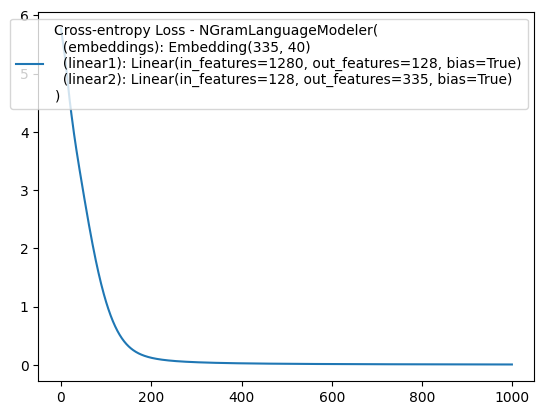

In [24]:
plt.plot(my_loss,label="Cross-entropy Loss - {}".format(model))
plt.legend()

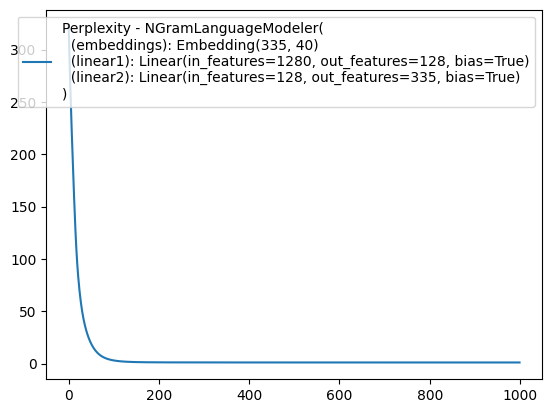

In [25]:
perplexity = np.exp(my_loss)
plt.plot(perplexity,label="Perplexity - {}".format(model))
plt.legend()

# Writing a song

In [26]:
write_song(model)

' little miss muffet sat on a tuffet , eating her curds , again it sir a know , ! on , a , merrily a , , , a she the the little star , how i wonder what you are ! up above the world so high , like a diamond in the sky . baa , baa , black sheep , have you any wool ? yes sir , yes sir , three bags full . jack and jill went up the hill to fetch a pail of water . jack fell down and broke his crown ,'